<a href="https://colab.research.google.com/github/HemiaoZhang/CEE316Project/blob/main/3_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [22]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


## Data Loading

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/signedDistance.mat'
img_rsd = []
img_bi = []
with h5py.File(path, 'r') as file:
  img_bi = np.array(file['img_bi'][:]) # instancex512x512
  img_rsd = np.array(file['img_rsd'][:]) # instancex512x512

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/CEE316
/content/gdrive/MyDrive/Colab Notebooks/CEE316


In [24]:
class CustomImageDataset(Dataset):
  def __init__(self, data, label, transform=None):
    self.data = data
    self.label = label
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]
    porosity = self.label[idx]

    if self.transform!=None:
      image = self.transform(image)
    return (image, porosity)

In [6]:
# 1,000 = 16 * 62 + 8
# 512x2.25=1152micron per side
full_dataset = CustomImageDataset(torch.tensor( img_rsd.reshape(-1,1,512,512), dtype=torch.float32),
                                  torch.tensor( 1-np.mean(img_bi, axis=(1,2)), dtype=torch.float32))
train_size = int(0.8 * len(full_dataset)) # 0.8-0.2 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
len(train_loader.dataset)

1600

total number of training data: 1600
min of data: 0.0
max of data: 1.0
length of the cubic area: 1152.0 microns


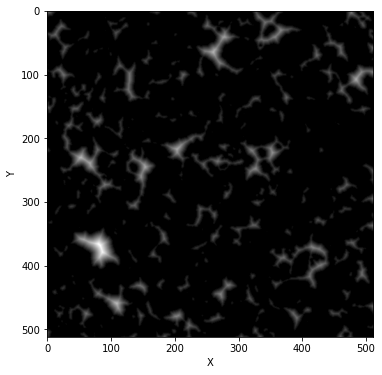

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("X")
ax.set_ylabel("Y")
print(f'total number of training data: {len(train_dataset)}')
print(f'min of data: {torch.min(train_dataset.dataset.data[0])}')
print(f'max of data: {torch.max(train_dataset.dataset.data[0])}')
print(f'length of the cubic area: {train_dataset.dataset.data[0].shape[1]*2.25} microns')
ax.imshow(train_dataset.dataset.data[0].reshape(512,512).detach().numpy(), cmap='gray')

## VAE Architecture

[sizing for hyperparameters](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
$$
O = \frac{I - F + P_{\text{start}} + P_{\text{end}}}{S} + 1
$$

torch.nn.**Conv2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

For rectangular image, with floor function

H(out)=⌊ [H(in)+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1] / stride[0] + 1 ⌋

W(out)=⌊ [W(in)+2×padding[1]−dilation[1]×(kernel_size[1]−1)−1] / stride[1] + 1 ⌋

torch.nn.**ConvTranspose2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

For rectangular image,

H(out)=(H(in)−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

W(out)=(W(in)−1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1

[expression for Kullback-Leibler divergence term](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

[equivalent result when $\mathcal{N_1(\mu,\sigma)}$ and $\mathcal{N_2(0,1)}$](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes?noredirect=1&lq=1)

[maximizing log-likelihood and minimizing Dkl](https://stfwn.com/articles/mle-is-min-kld/)

In [8]:
# define encoder
class VariationalEncoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=16, latent_dim=50):
    super().__init__()

    self.net = nn.Sequential(
        # floor((512-3+1+1)/2 + 1) = 256
        nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 256, 256
        nn.ReLU(),
        # floor((256-3+1+1)/2 + 1) = 128
        nn.Conv2d(out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 32, 128, 128
        nn.ReLU(),
        # floor((128-3+1+1)/2 + 1) = 64
        nn.Conv2d(2*out_channels, 4*out_channels, 3, stride=2, padding=1), # -> N, 64, 64, 64
        nn.ReLU(),
        # floor((64-3+1+1)/2 + 1) = 32
        nn.Conv2d(4*out_channels, 8*out_channels, 3, stride=2, padding=1), # -> N, 128, 32, 32
        nn.ReLU(),
        # floor((32-3+1+1)/2 + 1) = 16
        nn.Conv2d(8*out_channels, 16*out_channels, 3, stride=2, padding=1), # -> N, 256, 16, 16
        nn.ReLU(),
        # floor((16-3+1+1)/2 + 1) = 8
        nn.Conv2d(16*out_channels, 32*out_channels, 3, stride=2, padding=1), # -> N, 512, 8, 8
        nn.ReLU(),
        # floor((8-8)/1 + 1) = 1
        nn.Conv2d(32*out_channels, 32*out_channels, 8), # -> N, 512, 1, 1
        nn.ReLU(),
        nn.Flatten(),  # -> N, 512
        nn.Linear(32*out_channels, latent_dim), # -> N, 512
        nn.ReLU()
    )

    self.linear1 = nn.Linear(latent_dim, latent_dim)
    self.linear2 = nn.Linear(latent_dim, latent_dim)
    self.N = torch.distributions.Normal(0, 1) # standard normal distribution
    self.Dkl = 0 # Kullback-Leibler divergence

  def forward(self, x):
    x = self.net(x) 
    mu = self.linear1(x) # mean
    sigma = torch.exp(self.linear2(x)) # std
    z = mu + sigma*self.N.sample(mu.shape) # reparametrization
    self.Dkl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 0.5).sum()
    return z

# define decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=16, latent_dim=50):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 32*out_channels), # -> N, 64
        nn.ReLU()
    )

    self.conv = nn.Sequential(
        # (1-1)*1 + (8-1) + 1 = 8
        nn.ConvTranspose2d(32*out_channels, 32*out_channels, 8), # -> N, 512, 8, 8
        nn.ReLU(),
        # (8-1)*2-1-1 + (3-1) + 1 + 1 = 16
        nn.ConvTranspose2d(32*out_channels, 16*out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 256, 16, 16
        nn.ReLU(),
        # (16-1)*2-1-1 + (3-1) + 1 + 1 = 32
        nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 128, 32, 32
        nn.ReLU(),
        # (32-1)*2-1-1 + (3-1) + 1 + 1 = 64
        nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 64, 64, 64
        nn.ReLU(),
        # (64-1)*2-1-1 + (3-1) + 1 + 1 = 128
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 32, 128, 128
        nn.ReLU(),
        # (128-1)*2-1-1 + (3-1) + 1 + 1 = 256
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 256, 256
        nn.ReLU(),
        # (256-1)*2-1-1 + (3-1) + 1 + 1 = 512
        nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 512, 512
        nn.Sigmoid() # since min=0. max=1.
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 32*self.out_channels, 1, 1)
    output = self.conv(output)
    return output

# define autoencoder
class VariationalAutoencoder(nn.Module):
  def __init__(self, variational_encoder, decoder):
    super().__init__()
    self.encoder = variational_encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
out_channels = 16
latent_dim = 512
model = VariationalAutoencoder(VariationalEncoder(out_channels=out_channels, latent_dim=latent_dim), \
                               Decoder(out_channels=out_channels, latent_dim=latent_dim))
model

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(512, 512, kernel_size=(8, 8), stride=(1, 1))
      (13): ReLU()
      (14): Flatten(start_dim=1, end_dim=-1)
      (15): Linear(in_features=512, out_features=512, bias=True)
      (16): ReLU()
    )
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, b

## Training

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
num_epochs = 25
best_loss = np.inf
best_states = None
loss_history = []

for epoch in range(num_epochs):
  model.train()
  train_losses = []
  for batch, label in train_loader:
    optimizer.zero_grad()
   
    img = batch.to(device) # img.shape = torch.Size([batch_size, 1, 512, 512])
    recon = model(img)
    loss = loss_fn(recon, img) + model.encoder.Dkl
    
    loss.backward()
    optimizer.step()

    train_losses.append( loss.detach().item() )

  epoch_loss = np.mean(train_losses)
  if epoch_loss < best_loss:
    best_loss = np.copy(epoch_loss)
    best_states = copy.deepcopy( model.state_dict() )
  # record loss history
  if (epoch+1) % 5 == 0: print("epoch {:4d}, training loss = {:1.5e}".format(epoch+1, epoch_loss))
  loss_history.append(epoch_loss)
  # adjust the learning rate
  sch.step()

epoch    5, training loss = 1.05257e-02
epoch   10, training loss = 1.05241e-02
epoch   15, training loss = 1.05203e-02
epoch   20, training loss = 1.05124e-02
epoch   25, training loss = 1.05201e-02


In [14]:
# save the best state in the trained model
model.load_state_dict(best_states)
# print parameters from the first filter 
nlayers = 1
count = 0
for name, param in model.named_parameters():
    if param.requires_grad and count < nlayers:
        print(name, param.data[0][0])
        count += 1

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/vae_model_512x512.pth'
torch.save(best_states, path)

encoder.net.0.weight tensor([[ 0.0573,  0.1209,  0.1703],
        [ 0.0359, -0.0326, -0.1539],
        [-0.0928,  0.1665,  0.0590]])


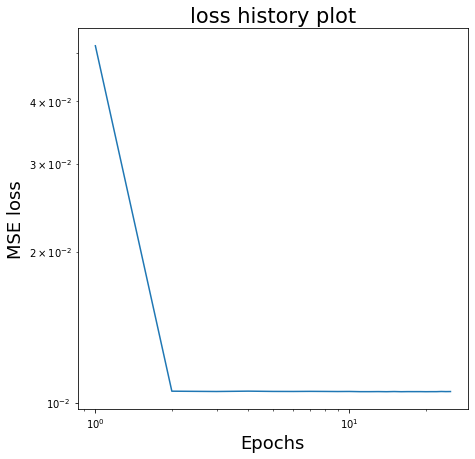

In [15]:
plt.figure(0,figsize=(7,7))
plt.loglog(np.arange(1,num_epochs+1), loss_history)
plt.title('loss history plot', fontsize=21)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.show()

## Embedding

In [16]:
def binarization(img, threshold=0.5, lower=0, upper=1):
  '''
  Take in an image (numpy.array) with pixel/voxel values in [0,1] and,
  convert to a binary image of {0, 1}
  '''
  return np.where(img<=threshold, lower, upper)

def plot_latent_2d(autoencoder, loader, z1=0, z2=1):
  '''
  plot z1-th and z2-th feature in the encoded feature vector z
  '''
  plt.figure(figsize=(6,6))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  min = torch.min(loader.dataset.dataset.label)
  max = torch.max(loader.dataset.dataset.label)
  for batch, label in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy()  
    plt.scatter(z[:, z1], z[:, z2], c=label, cmap='viridis')
    plt.clim(min, max) # for porosity
  plt.colorbar().set_label('Porosity',rotation=270)

def plot_latent_boxwhisker(autoencoder, loader):
  '''
  plot the distribution of each embedded features, and
  return a vector of mean of each feature
  '''
  z_array = np.array([])
  for batch, label in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy() # -> N, latent_dim
    if z_array.shape[0]==0:
      z_array = z
    else:
      z_array = np.vstack((z_array, z))

  plt.figure(figsize=(12,6))
  print(f'number of training samples: {z_array.shape[0]}')
  print(f'number of features: {z_array.shape[1]}')
  plt.boxplot(z_array)
  return np.mean(z_array, axis=0)

def plot_reconstructed(autoencoder, z, z1=0, z2=1, r1=(5, 20), r2=(5, 20), n=5):
  '''
  generate image from given encoded feature vector z with
  altering feature z1 and z2
  '''
  w = 512 # pixel width
  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r2, n)):
    for j, x in enumerate(np.linspace(*r1, n)):
      z[0][z1] = x
      z[0][z2] = y
      z = torch.tensor(z, dtype=torch.float32).to(device)
      x_hat = autoencoder.decoder(z)
      x_hat = x_hat.reshape(w, w).cpu().detach().numpy()
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
  plt.figure(0, figsize=(12,12))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  plt.gray()
  plt.imshow(img, extent=[*r1, *r2], vmin=0., vmax=1.)

  plt.figure(1, figsize=(12,12))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  plt.gray()
  plt.imshow( binarization(img), extent=[*r1, *r2], vmin=0., vmax=1.)  

number of training samples: 1600
number of features: 512


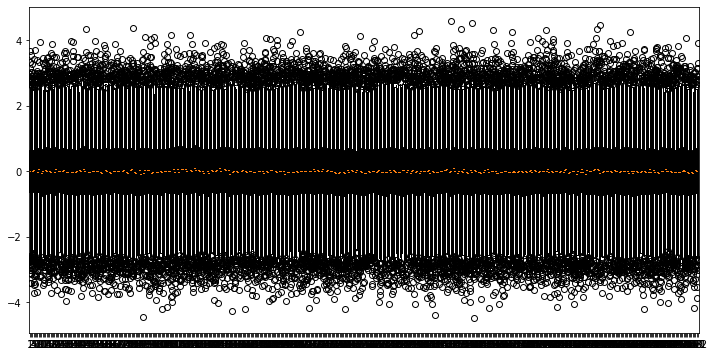

In [27]:
mean_embedding = plot_latent_boxwhisker(model, train_loader)

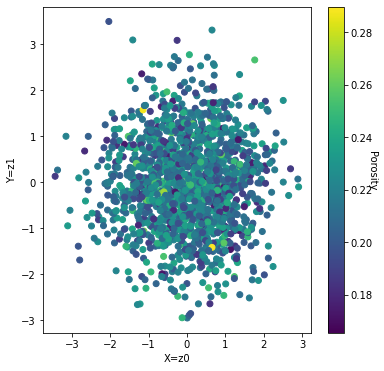

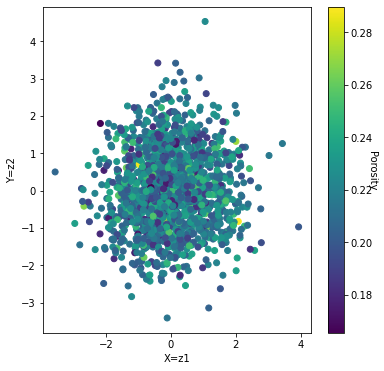

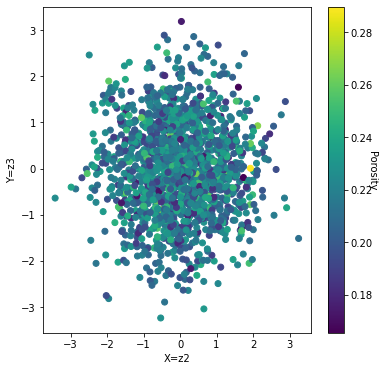

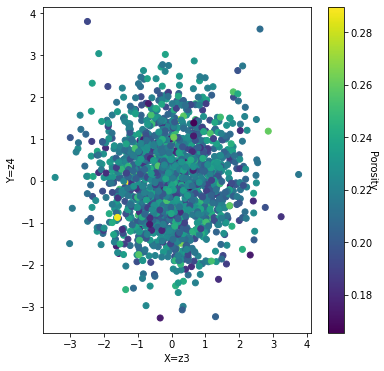

In [28]:
plot_latent_2d(model, train_loader, z1=0, z2=1)
plot_latent_2d(model, train_loader, z1=1, z2=2)
plot_latent_2d(model, train_loader, z1=2, z2=3)
plot_latent_2d(model, train_loader, z1=3, z2=4)

In [ ]:
embedding = model.encoder(train_loader.dataset.data[0].view(-1,1,50,50).to(device))
embedding = embedding.cpu().detach().numpy() 

s = 100 # span
plot_reconstructed(model, mean_embedding, z1=0, z2=1, r1=(int(mean_embedding[0])-s, int(mean_embedding[0])+s), r2=(int(mean_embedding[1])-s, int(mean_embedding[1])+s))
#plot_reconstructed(model, mean_embedding, z1=0, z2=2, r1=(100, 125), r2=(30, 55))
#plot_reconstructed(model, mean_embedding, z1=0, z2=3, r1=(100, 125), r2=(90, 115))
#plot_reconstructed(model, mean_embedding, z1=2, z2=3, r1=(10, 30), r2=(10, 30))

## Testing

In [25]:
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
test_img = []
test_recon = []
for batch, label in test_loader: # one per batch
  img = batch.to(device)  
  recon = model(img)
  test_img.append( img.cpu().detach().numpy() )
  test_recon.append( recon.cpu().detach().numpy() )

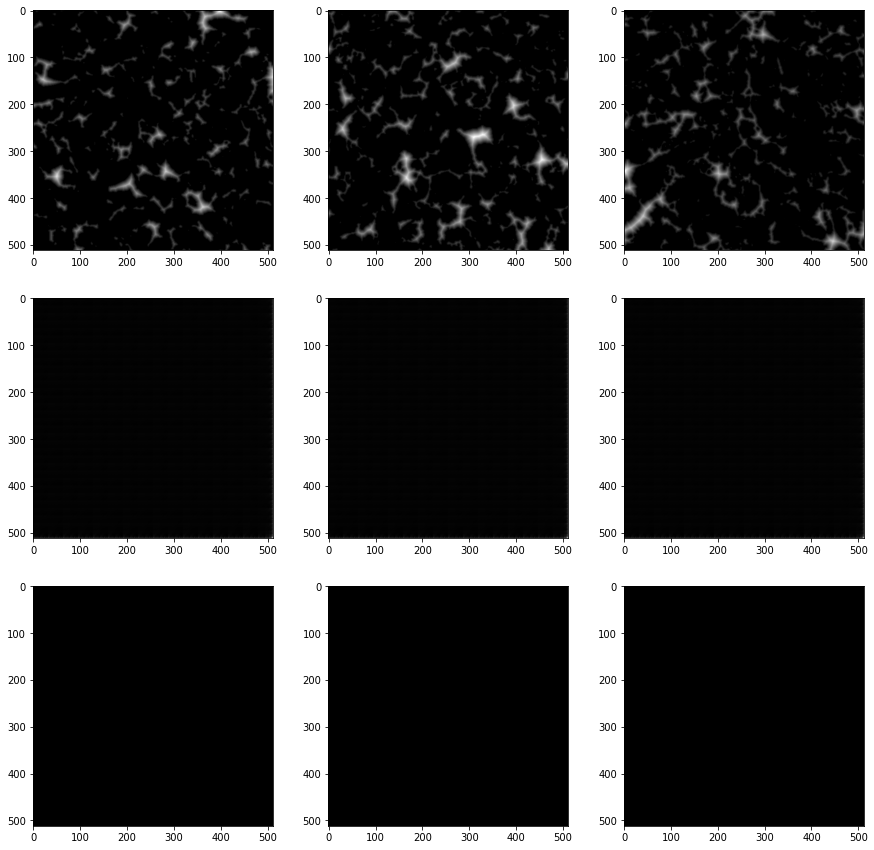

In [26]:
# randonly select 10 testing cases
n2show = 3
idx = np.random.randint(0, len(test_loader.dataset), n2show)
#idx = range(10)
plt.figure(figsize=(15,15))
plt.gray()
for k in range(n2show):
  plt.subplot(3,n2show,k+1) # first line
  plt.imshow(test_img[idx[k]].reshape(512, 512), vmin=0., vmax=1.)

  plt.subplot(3,n2show,n2show+k+1) # second line
  plt.imshow( test_recon[idx[k]].reshape(512, 512) )#, vmin=0., vmax=1. )
  
  plt.subplot(3,n2show,2*n2show+k+1) # third line
  plt.imshow( binarization( test_recon[idx[k]].reshape(512, 512) ), vmin=0., vmax=1. )

In [ ]:
# end runtime
from google.colab import runtime

In [ ]:
runtime.unassign()